In [1]:
%pip install sentencepiece
%pip install wandb

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [1]:
import json
from torch.utils.data import DataLoader
import sentencepiece as spm
from dataset import TinyStoriesDataset
from train import *
from model import *
import torch
import matplotlib.pyplot as plt

/home/kolya/.local/lib/python3.10/site-packages/torch/cuda/amp/grad_scaler.py:118: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


In [3]:
!wget --quiet --show-progress "https://huggingface.co/datasets/roneneldan/TinyStories/resolve/main/TinyStories_all_data.tar.gz"

... .......... .......... 79%  137M 2s
1245700K .......... .......... .......... .......... .......... 79%  315M 2s
1245750K .......... .......... .......... .......... .......... 79%  378M 2s
1245800K .......... .......... .......... .......... .......... 79%  258M 2s
1245850K .......... .......... .......... .......... .......... 79%  121M 2s
1245900K .......... .......... .......... .......... .......... 79%  105M 2s
1245950K .......... .......... .......... .......... .......... 79%  151M 2s
1246000K .......... .......... .......... .......... .......... 79%  339M 2s
1246050K .......... .......... .......... .......... .......... 79%  552M 2s
1246100K .......... .......... .......... .......... .......... 79% 81.5M 2s
1246150K .......... .......... .......... .......... .......... 79%  430M 2s
1246200K .......... .......... .......... .......... .......... 79%  135M 2s
1246250K .......... .......... .......... .......... .......... 79%  591M 2s
1246300K .......... .......... ......

In [4]:
!tar xvzf TinyStories_all_data.tar.gz

./
./data22.json
./data34.json
./data18.json
./data04.json
./data07.json
./data30.json
./data47.json
./data15.json
./data21.json
./data39.json
./data17.json
./data03.json
./data01.json
./data36.json
./data14.json
./data06.json
./data28.json
./data43.json
./data23.json
./data38.json
./data40.json
./data10.json
./data19.json
./data20.json
./data29.json
./data11.json
./data46.json
./data33.json
./data25.json
./data42.json
./data13.json
./data49.json
./data27.json
./data24.json
./data32.json
./data41.json
./data26.json
./data37.json
./data09.json
./data05.json
./data45.json
./data16.json
./data00.json
./data48.json
./data12.json
./data02.json
./data44.json
./data35.json
./data31.json
./data08.json


In [38]:
!mv data*.json jsons/

mv: cannot stat 'data*.json': No such file or directory


In [2]:
%load_ext autoreload
%autoreload 2

In [8]:
import json
with open("jsons/data00.json") as f:
    string = f.readline()
    js = json.loads(string)
    for story in js:
        print("-----------")
        print(story["story"])
        break

-----------


Lily and Ben are friends. They like to play in the park. One day, they see a big tree with a swing. Lily wants to try the swing. She runs to the tree and climbs on the swing.
"Push me, Ben!" she says. Ben pushes her gently. Lily feels happy. She swings higher and higher. She laughs and shouts.
Ben watches Lily. He thinks she is cute. He wants to swing too. He waits for Lily to stop. But Lily does not stop. She swings faster and faster. She is having too much fun.
"Can I swing too, Lily?" Ben asks. Lily does not hear him. She is too busy swinging. Ben feels sad. He walks away.
Lily swings so high that she loses her grip. She falls off the swing. She lands on the ground. She hurts her foot. She cries.
"Ow, ow, ow!" she says. She looks for Ben. She wants him to help her. But Ben is not there. He is gone.
Lily feels sorry. She wishes she had shared the swing with Ben. She wishes he was there to hug her. She limps to the tree. She sees something hanging from a branch. It is Be

In [21]:
#tokenization file
import os
import json

files = sorted(os.listdir("jsons/"))
with open("tokenization_file", "w+") as f:
    for file in tqdm(files[:10]):
        with open(f"jsons/{file}", 'r') as g:
            stories = json.loads(g.readline())
            for story in stories:
                f.write(story["story"])
        g.close()
f.close()

spm.SentencePieceTrainer.train(
    input="tokenization_file",
    vocab_size=5000,
    model_type="bpe",
    model_prefix="tiny_stories_5k",
    pad_id=0, bos_id=1, eos_id=2, unk_id=3
)
tokenizer = spm.SentencePieceProcessor(model_file="tiny_stories_5k.model")

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:08<00:00,  1.21it/s]
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: tokenization_file
  input_format: 
  model_prefix: tiny_stories_5k
  model_type: BPE
  vocab_size: 5000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 3
  bos_id: 1
  eos_id: 2
  pad_id: 0
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential_privacy: 0
  different

In [47]:
from tqdm import tqdm
#datasets

train_dataset = TinyStoriesDataset(files=[files[0]], tokenizer=tokenizer, dataset_size=100)
val_dataset = TinyStoriesDataset(files=[files[0]], tokenizer=tokenizer, dataset_size=100)

        

100%|██████████| 100000/100000 [00:50<00:00, 1990.11it/s]


torch.Size([100, 256])


100%|██████████| 100000/100000 [00:49<00:00, 2031.03it/s]


torch.Size([100, 256])


In [28]:
#!g2.1
tokenizer.decode(tokenizer.encode("Hello, \" How are you??? I want to meet with you! I don't want to speak in chat", add_eos=True))


'Hello, " How are you??? I want to meet with you! I don\'t want to speak in chat'

In [61]:
#!g2.1
len(val_dataset)

50000

In [84]:
#!g2.1
device = torch.device("cuda:0")

In [85]:
#!g2.1
!nvidia-smi

Mon Nov 27 21:07:58 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:8C:00.0 Off |                    0 |
| N/A   34C    P0    89W / 500W |   1683MiB / 81920MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [51]:
#!g2.1
decoder = BoutiqueLM(
    vocab_stories_size=5000,
    num_layers=1,
    num_heads=8,
    hidden_dim=128,
    activation=nn.GELU,
    max_len=10000
)#.to(device)

In [37]:
#!g2.1
sum(p.numel() for p in decoder.parameters())

1476608

In [52]:
#!g2.1
num_workers = 2
lr = 1e-3
optimizer = torch.optim.AdamW(decoder.parameters(), lr=lr, betas=(0.9, 0.95), weight_decay=0)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, max_lr=lr, total_steps=150, pct_start=0.1, final_div_factor=10, div_factor=10)
train_loader = DataLoader(
    train_dataset,
    batch_size=100,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=100,
    shuffle=False,
    num_workers=num_workers
)

In [67]:
#!g2.1
def _save_checkpoint(model, optimizer, epoch, save_best=False, only_best=False):
        """
        Saving checkpoints

        :param epoch: current epoch number
        :param save_best: if True, rename the saved checkpoint to 'model_best.pth'
        """
        arch = type(model).__name__
        state = {
            "arch": arch,
            "epoch": epoch,
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
        }
        filename = str("checkpoint-epoch{}.pth".format(epoch))
        if not (only_best and save_best):
            torch.save(state, filename)
#             logger.info("Saving checkpoint: {} ...".format(filename))
        if save_best:
            best_path = str("model_best.pth")
            torch.save(state, best_path)
#             logger.info("Saving current best: model_best.pth ...")

In [12]:
#!g2.1
wandb.login(key="9f8480fbfcfd1d06b91b59aa5d23ed5482fdee2e", relogin=True)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/jupyter/.netrc


True

In [88]:
#!g2.1
wandb.init(project="DL bhw-1",
          entity="kilka74",
          name="full data with warmup=0.1 in bfloat16, fixed transformer, max_len=10k",
          config={
              "batch_size":2048,
              "seq_len":256,
              "embed_dim":512,
              "num_heads":8,
              "num_layers":8,
              "tokenizetion":"BPE",
              "vocab_size":5000,
              "lr": 1e-3,
              "train_size": 4900000,
              "weight_decay":0,
              "beta1":0.9,
              "beta2":0.95
          })

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
/kernel/lib/python3.9/site-packages/IPython/html.py:12: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  warn("The `IPython.html` package has been deprecated since IPython 4.0. "
wandb: Currently logged in as: kilka74. Use `wandb login --relogin` to force relogin


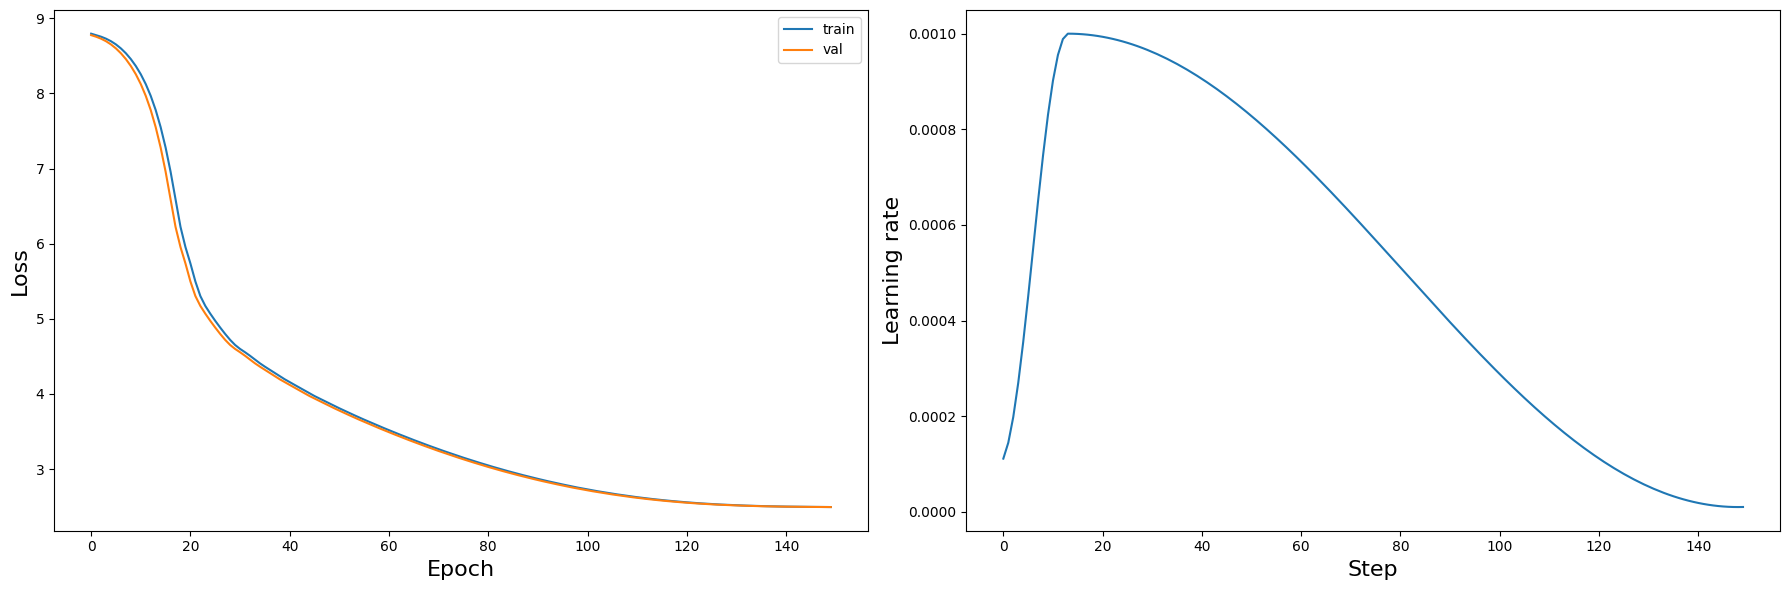

In [53]:
#!g2.1
train(
    model=decoder,
    num_epochs=150,
    optimizer=optimizer,
    scheduler=scheduler,
    train_loader=train_loader,
    val_loader=val_loader,
    wandb_log=False,
    # device=torch.device("cuda:0")
)

# _save_checkpoint(decoder, optimizer, 100)
# wandb.finish()

In [70]:
#!g2.1
wandb.finish()

In [91]:
tokenizer = spm.SentencePieceProcessor(model_file="tiny_stories_5k.model")
d = torch.load('checkpoint-epoch3.pth', map_location=torch.device('cpu'))

In [52]:
d['state_dict']

OrderedDict([('embeds.weight',
              tensor([[-0.2969,  0.6953, -0.2930,  ..., -0.3613, -1.7578, -0.2539],
                      [-1.9062,  0.5273, -0.8984,  ...,  0.8516,  0.6836,  0.5664],
                      [-0.2324, -0.4570, -2.1562,  ...,  0.1436, -0.9531,  0.9844],
                      ...,
                      [-0.1504,  1.3750, -0.1729,  ...,  0.2197,  0.5000,  0.6172],
                      [-0.7773, -0.3730, -1.6328,  ...,  0.9766, -0.1934,  0.0981],
                      [-0.8398, -0.2129,  0.6523,  ..., -1.0469,  1.7578,  0.7812]],
                     dtype=torch.bfloat16)),
             ('positional_encoding.sin',
              tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
                         0.0000e+00,  0.0000e+00],
                       [ 8.3984e-01,  8.2031e-01,  8.0078e-01,  ...,  1.1587e-04,
                         1.0872e-04,  1.0872e-04],
                       [ 9.1016e-01,  9.3750e-01,  9.5703e-01,  ...,  2.3174e-04,
   

In [92]:
model = BoutiqueLM(
    vocab_stories_size=5000,
    num_layers=8,
    num_heads=8,
    hidden_dim=512,
    activation=nn.GELU,
    max_len=10000
)

model.load_state_dict(d['state_dict'])

<All keys matched successfully>

In [129]:
from train import generate_nucleus
prompt = "It was a great day! "
print(generate_nucleus(model=model, tokenizer=tokenizer, batch_size=1, prefix=prompt, max_len=200, tau=0.7))
# print(generate_story_temp(model, tokenizer=tokenizer, beginning=prompt, story_length=100, k=5, tau=0.6))

tensor([[ 197,   31,    6,  743,   72, 4980]])
It was a great day! in the summer. The months were full of fun, and love.Once upon a time, there was a little boy named Tim. He had a dog. The boy's name was Max. Tim and the dog were his best friend., was a girl, and they were both very nice., and they were not.. Tim was sad too.Once upon a time, there was a little boy named Tim. He had a big, filthy body. lived in a big, messy room. Tim's toys were not... Tim was happy too. They were friends. is not. Tim and the girl are the best.Once upon a time, there was a big castle. In the castle lived a rich king. The castle was the king. was the king. The people liked the youth. The king was sad.. is when you are bad. The end.Once upon a time,


In [35]:
import torch


class Rotary(torch.nn.Module):
    def __init__(self, dim, base=10000):
        super().__init__()
        inv_freq = 1.0 / (base ** (torch.arange(0, dim, 2).float() / dim))
        self.register_buffer("inv_freq", inv_freq)
        self.seq_len_cached = None
        self.cos_cached = None
        self.sin_cached = None

    def forward(self, x, seq_dim=1):
        seq_len = x.shape[seq_dim]
        if seq_len != self.seq_len_cached:
            self.seq_len_cached = seq_len
            t = torch.arange(x.shape[seq_dim], device=x.device).type_as(self.inv_freq)
            freqs = torch.einsum("i,j->ij", t, self.inv_freq)
            emb = torch.cat((freqs, freqs), dim=-1).to(x.device)
            self.cos_cached = emb.cos()[:, None, None, :]
            self.sin_cached = emb.sin()[:, None, None, :]
        return self.cos_cached, self.sin_cached


# rotary pos emb helpers:

def rotate_half(x):
    x1, x2 = x[..., : x.shape[-1] // 2], x[..., x.shape[-1] // 2 :]
    return torch.cat(
        (-x2, x1), dim=x1.ndim - 1
    )  # dim=-1 triggers a bug in torch < 1.8.0


@torch.jit.script
def apply_rotary_pos_emb(q, k, cos, sin):
    return (q * cos) + (rotate_half(q) * sin), (k * cos) + (rotate_half(k) * sin)


from model import RotaryEmbreddings
Rot = RotaryEmbreddings(256)
a = torch.randn((2, 4, 256))
my_rot = Rot(a)

Rot_true = Rotary(256)
x, y = Rot_true(a)

true_rot, _ = apply_rotary_pos_emb(a, a, x, y)

print(torch.norm(true_rot - my_rot) / torch.norm(true_rot))

tensor(0.3496)


In [36]:
torch.randn((3,5)).transpose(0, 1).shape

torch.Size([5, 3])